# Incremental Forward Stagewise Regression

Here, we discuess another LAR-like algorithm: incremental forward stagewise regression. This algorithm works by repeatedly updating (by a small amount $\epsilon$ the coefficient most correlated with the current residulals. This algorithm is summarized as follows:

   1. Start with the residual $\mathbf{r}$ equal to $\mathbf{y}$ and $\beta_1, \beta_2, \cdots,\beta_p=0$. Nor,alized the predictor have 0 mean and unit variance.
   
   2. Find the predictor $\mathbf{x}_j$ that has the highest correlation with $\mathbf{r}$
   
   3. Update $\beta_j \leftarrow \beta_j + \delta_j$, where $\delta_j = \epsilon \cdot \text{sign}\left(\langle\mathbf{x}_j, r\rangle\right)$. $\epsilon >0$ is a small step size
   
   4. Update the residual $\mathbf{r} \leftarrow \mathbf{r} - \delta_j \mathbf{x}_j$
   
   5. Repeat steps 2-4 until all the residuals are uncorrelated with all the predictors.

**NOTE**: if $\delta_j = \langle\mathbf{x}_j, r\rangle$, then this is exaclty the standard forward stagewise procedure.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ml_datasets.esl import ProstateCancer
from sklearn import preprocessing

In [2]:
prostate_cancer = ProstateCancer(verbose=0)

In [3]:
df = prostate_cancer.load()

train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(df_x[train_test=='T'].values)
x_test = scaler.transform(df_x[train_test=='F'].values)

y_train_temp = df_y[train_test=='T'].copy().values
y_train = y_train_temp - np.mean(y_train_temp)

y_test_temp = df_y[train_test=='F'].copy().values
y_test = y_test_temp  - np.mean(y_train_temp)

In [37]:
class IncForwStageRegression:
    def __init__(self, **kwargs):
        self.num_iter = kwargs.get('num_iter', 10)
        self.step_size = kwargs.get('step_size', 0.01)
        
    def fit(self, x, y):
        r = y.copy()
        self.beta_path = np.zeros((self.num_iter, x.shape[1]))
        beta_hat = np.zeros(x.shape[1])
        for i in range(self.num_iter):
            corr = x.T @ r
            best_predictor = np.argmax(np.abs(corr))
            delta = self.step_size * np.sign(x[:, best_predictor].T @ r)
            beta_hat[best_predictor] += delta
            self.beta_path[i, :] = beta_hat
            r -= delta * x[:, best_predictor]

In [38]:
num_iter = 230
ifsw = IncForwStageRegression(num_iter=num_iter)
ifsw.fit(x_train, y_train)

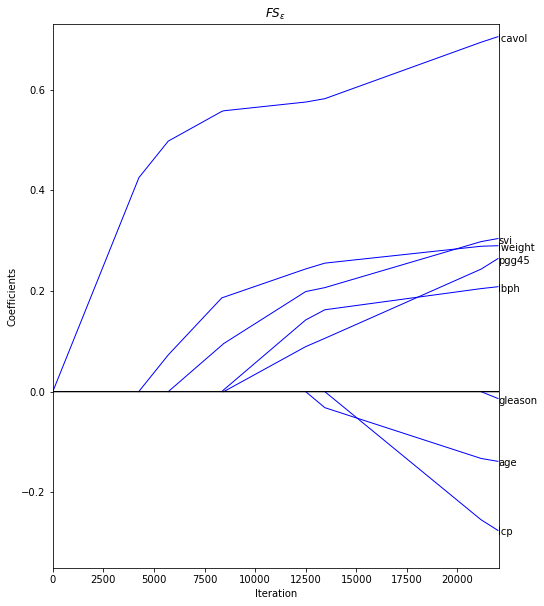

In [85]:
xx = np.arange(0, num_iter + 1, 1)
beta_path = np.vstack([np.zeros_like(ifsw.beta_path[0, :]).reshape(1, -1), ifsw.beta_path])

column_names = prostate_cancer.meta[:-1]
plt.figure(figsize=(8, 10))
plt.xlim([-10, num_iter + 50])
plt.ylim([-0.35, 0.73])

for i in range(x_train.shape[1]):
    idx_nonzero = np.where(beta_path[:, i] != 0)[0]
    idx_nonzero = np.append(idx_nonzero[0] - 1, idx_nonzero)
    beta_path_temp = beta_path[idx_nonzero, i]
    s_temp = xx[idx_nonzero]
    plt.plot(s_temp, beta_path_temp, 'b-', linewidth=1.0)
    plt.annotate(column_names[i], xy=(num_iter + 10, beta_path_temp[-1] - 0.01))

x0 = np.arange(-10, num_iter + 50, 1)
plt.plot(x0, np.zeros_like(x0), 'k-', linewidth=1.3)
plt.xlabel('Iteration')
plt.ylabel('Coefficients')
plt.title('$FS_\epsilon$')
plt.show()

In [72]:
num_iter = 22000
step_size = 0.0001
ifsw = IncForwStageRegression(num_iter=num_iter, step_size=step_size)
ifsw.fit(x_train, y_train)

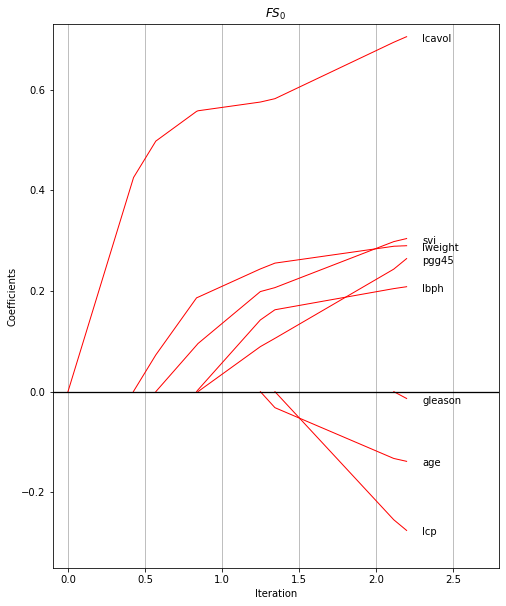

In [86]:
xx = np.arange(0, num_iter + 1, 1) * step_size
beta_path = np.vstack([np.zeros_like(ifsw.beta_path[0, :]).reshape(1, -1), ifsw.beta_path])

column_names = prostate_cancer.meta[:-1]
plt.figure(figsize=(8, 10))
plt.xlim([-0.1, 2.8])
plt.ylim([-0.35, 0.73])

for i in range(x_train.shape[1]):
    idx_nonzero = np.where(beta_path[:, i] != 0)[0]
    idx_nonzero = np.append(idx_nonzero[0] - 1, idx_nonzero)
    beta_path_temp = beta_path[idx_nonzero, i]
    s_temp = xx[idx_nonzero]
    plt.plot(s_temp, beta_path_temp, 'r-', linewidth=1.0)
    plt.annotate(column_names[i], xy=(2.3, beta_path_temp[-1] - 0.01))


x0 = np.arange(-0.1, 3, 0.1)
plt.plot(x0, np.zeros_like(x0), 'k-', linewidth=1.3)
plt.xlabel('Iteration')
plt.ylabel('Coefficients')
plt.title('$FS_0$')
plt.grid(axis='x')
plt.show()